In [1]:
import os
import math
from datetime import datetime

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion, HeatDiffusion_Revised
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_samples

import matplotlib.pyplot as plt
import itertools
from typing import Optional
import shutil


# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

model_path = os.path.join(args['log_path'], args['model_path'])

u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
noise_steps = args['noise_steps']
sample_num = args['sample_num']
time_type = args['time_type']

iterations = args['iterations']
train_lr = args['train_lr']
batch_size = args['batch_size'] #args['batch_size']

/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate_samples(score_map, x_t)    # output: (B,2)
            return score, score_map.permute(0,2,3,1)
        else:
            return score_map.permute(0, 2, 3, 1)
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')


  0%|          | 0/6000 [00:00<?, ?it/s]

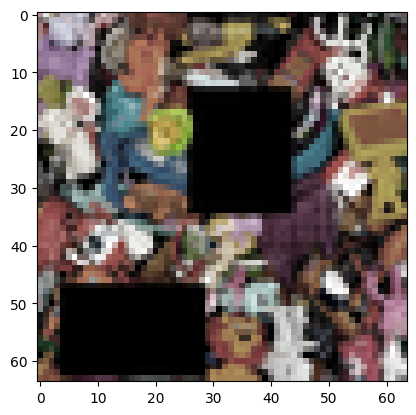

  0%|          | 0/6000 [00:01<?, ?it/s]


RuntimeError: No active exception to reraise

In [3]:
# Train with random single goal
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('./runs/heat/', current_time)
writer = SummaryWriter(log_dir)
shutil.copy('./scorefield/configs/heat_diffusion.yaml', writer.log_dir)

# background = draw_obstacles_pil(bg, obstacle_pos)
# obstacle_masks = convert_to_obstacle_masks(batch_size, background[0].size, img_size, obstacle_pos)

for iters in tqdm(range(iterations)):
    obstacle_masks = randgen_obstacle_masks(batch_size, img_size)
    background = draw_obstacles_pixel(bg, obstacle_masks)
    goals = gen_goals(goal_bounds, batch_size, img_size, obstacles=obstacle_masks)
    goal = (torch.rand(batch_size, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) * 0.1 + goals
    obs = overlay_goal(background, img_size, wastes, goal)
    
    optim.zero_grad()

    losses = []
    target_scores = []
    pred_scores = []
    
    for i in range(1, noise_steps+1):
        t = (torch.ones(1) * i).long().to(device)
        with torch.no_grad():
            _, score, _, x_t = diffusion.forward_diffusion(t.repeat(batch_size), goal, sample_num, obstacle_masks)

        pred_score, _ = model(obs, t, x_t)
        target_score = score * diffusion.std[i-1] #.view(score.size(0), 1, 1)

        squared_diff = torch.sum((pred_score - target_score)**2, dim=-1)  # there are sample_num versions of scores in a single batch

        losses.append(torch.mean(squared_diff))
        target_scores.append(target_score)
        pred_scores.append(pred_score)
    
    loss = sum(losses)/len(losses)
    loss.backward()
    optim.step()
    target_scores = torch.stack(target_scores)
    pred_scores = torch.stack(pred_scores)

    target_score_norm = torch.norm(target_scores.detach(), dim=-1)
    pred_score_norm = torch.norm(pred_scores.detach(), dim=-1)

    dotprod = torch.sum(target_scores.detach() * pred_scores.detach(), dim=-1)
    cosine_sim = dotprod / (torch.norm(target_scores.detach(), dim=-1) * torch.norm(pred_scores.detach(), dim=-1)+1e-8)
    
    writer.add_scalar("Loss/train", loss.item(), iters)
    writer.add_scalar("Norm/target_score", torch.mean(target_score_norm).item(), iters)
    writer.add_scalar("Norm/pred_score", torch.mean(pred_score_norm).item(), iters)
    writer.add_scalar("Similarity/dot_product", torch.mean(dotprod).item(), iters)
    writer.add_scalar("Similarity/cosine_similarity", torch.mean(cosine_sim).item(), iters)
    
    # if iters % (iters//10) == 0:
    #     print(f'epoch {iters} : {loss.item()}')
        
    if iters == iterations // 2:
        torch.save(model.state_dict(), os.path.join(writer.log_dir, 'model_params_half.pt'))

torch.save(model.state_dict(), os.path.join(writer.log_dir, 'model_params.pt'))
            
writer.close()


In [ ]:
# Train with random single goal
writer = SummaryWriter()
shutil.copy('./scorefield/configs/heat_diffusion.yaml', writer.log_dir)
# obstacle_masks = randgen_obstacle_masks(epochs, img_size)
# background = draw_obstacles_pixel(bg, obstacle_masks)

background = draw_obstacles_pil(bg, obstacle_pos)
obstacle_masks = convert_to_obstacle_masks(noise_steps, background[0].size, img_size, obstacle_pos)

for epoch in range(epochs):
    for iters in tqdm(range(iterations)):
        goals = gen_goals(goal_bounds, random_goals, img_size, obstacles=obstacle_masks)
        goal = (torch.rand(noise_steps, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) \
                    * 0.1 + goals.repeat(noise_steps, 1, 1)

        obs = overlay_goal(background, img_size, wastes, goal)
        optim.zero_grad()

        t = torch.arange(1, noise_steps+1, device=device)
        with torch.no_grad():
            _, score, _, x_t = diffusion.forward_diffusion(t, goal.squeeze(1), sample_num, obstacle_masks)
        pred_score, _ = model(obs, t, x_t)

        target_score = score * diffusion.std.view(score.size(0), 1, 1)

        losses = []
        cos_losses = []
        for b in range(score.shape[0]):
            batch_mseloss = F.mse_loss(pred_score[b], target_score[b]) / 2
            losses.append(batch_mseloss)
        loss = (sum(losses) / len(losses))
        loss.backward()
        optim.step()

        target_score_norm = target_score.detach().norm(dim=-1).mean(dim=-1)
        pred_score_norm = pred_score.detach().norm(dim=-1).mean()
        dotprod = torch.sum(target_score.detach().view(noise_steps, -1) * pred_score.detach().reshape(noise_steps, -1), dim=-1)
        cosine_sim = torch.sum(target_score.detach().view(noise_steps, -1) * pred_score.detach().reshape(noise_steps, -1), dim=-1) / \
                            (torch.norm(target_score.detach().view(noise_steps, -1), dim=-1) * torch.norm(pred_score.detach().reshape(noise_steps, -1), dim=-1))


    writer.add_scalar("Loss/train", loss.item(), iters)
    writer.add_scalar("Norm/target_score", target_score_norm.mean().item(), iters)
    writer.add_scalar("Norm/pred_score", pred_score_norm.mean(dim=-1).item(), iters)
    writer.add_scalar("Similarity/dot_product", dotprod.mean(dim=-1).item(), iters)
    writer.add_scalar("Similarity/cosine_similarity", cosine_sim.mean(dim=-1).item(), iters)

        # if iters % 100 == 0:
        #     print(f"iter {iters}: {loss.item()}")
    if epoch == iterations // 2:
        torch.save(model.state_dict(), os.path.join(writer.log_dir, 'model_params_half.pt'))

torch.save(model.state_dict(), os.path.join(writer.log_dir, 'model_params.pt'))
            
writer.close()


In [ ]:
# Train with single + multiple goals

train_goal_num = goal_num * (2**(goal_num - 1)) # if 3 goals: 12
train_goals = [len(list(itertools.combinations([i for i in range(goal_num)], i+1))* (i+1)) \
               for i in range(goal_num)] # if 3 goals: [3, 6, 3]
train_comb = [len(list(itertools.combinations([i for i in range(goal_num)], i+1))) \
              for i in range(goal_num)] # just a list of combinations of goal num. if 3: [3, 3, 1]

obstacle_masks = randgen_obstacle_masks(1, img_size)[0].repeat(train_goal_num, 1, 1)
background = draw_obstacles_pixel(bg, obstacle_masks)

assert batch_size % train_goal_num == 0, 'batch size has to be divided by the goal number'
n = batch_size // train_goal_num  # if 3 goals: batch -> n * 12 


for iters in tqdm(range(train_goal_num * iterations)):    
    goals = gen_goals(goal_bounds, train_goal_num, obstacle_masks)
    goal_pos = (torch.rand(train_goal_num, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) \
                    * 0.1 + goals
    
    optim.zero_grad()
    
    obs = []
    st = 0
    for i, t in enumerate(train_goals):
        if i == 0: 
            obs.append(overlay_goal(background, img_size, wastes, goal_pos[st:st + n * t]))
        else:
            obs.append(overlay_images(background, img_size, wastes, goal_pos[st:st + n * t], i+1))
        st = st + n * t
    x0 = goal_pos.unsqueeze(1)
    obs = torch.cat(obs, dim=0)
    raise
    
    # duplicate obs to match the size with x0
    duplicates = []
    for i, tr in enumerate(train_comb):
        if i > 0: 
            duplicates.append(obs[n*prev_tr:n*(prev_tr + tr)].repeat(i,1,1,1))
            tr = prev_tr + tr
        prev_tr = tr

    # TODO: Below new_obs is only capable when the goal number is 3.
    comb_sum = [0] + [n*(train_comb[c]+train_comb[c+1]) for c in range(len(train_comb)-1)]
    new_obs = torch.cat([obs[comb_sum[n//2]:comb_sum[n//2+1]] if n%2 == 0 else duplicates[n-1] \
                         for n in range(len(comb_sum)-1)*2], dim=0)
#     new_obs = torch.cat([
#         obs[:n*(train_comb[0]+train_comb[1])],
#         duplicates[0],
#         obs[n*(train_comb[0]+train_comb[1]):n*(train_comb[0]+train_comb[1]+train_comb[2])],
#         duplicates[1],
#         obs[14:]
#     ], dim=0)
        
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    score, _, x_t = diffusion.forward_diffusion(x0, t)
    score_pred = model(new_obs, t, x_t)
    loss =  F.l1_loss(score, score_pred)

    loss.backward()
    optim.step()
    
    if iters % (epochs//10) == 0:
        print(f"iter {iters}: {loss.item()}")


In [ ]:
model.load_state_dict(torch.load(f'./logs/pretrained/rand_goal_heat_n:{noise_steps}_h:{max_heat_step}_1.pt'))

In [ ]:
score, _= model(obs_T, (torch.ones(1) * 1).long().to(device), torch.tensor([[[0., -0.4]]]))
score * 0.05 /diffusion.std[1] * (img_size/2) 

In [ ]:
np.save('./results/heat/eval.npy', ims)

In [ ]:
np.save('./results/new_goals_video/img_list.npy', imgs)